## SARIMAX

1. SARIMAX captura la estacionalidad semanal (patrones que se repiten en un período fijo). Los datos diarios de accesos tienen un ciclo semanal fuerte ($s=7$). El modelo SARIMAX inlcuye parámetros estacionales  ($\mathbf{P, D, Q}$) que permiten modelar esta repetición. Su optimización encontró el orden estacional $\mathbf{(1, 1, 1)_7}$, confirmando que la estacionalidad semanal es el factor dominante.

        Ojo: Un modelo ARIMA simple (sin la S) no podría capturar esta variación semanal y solo vería la dependencia de los días inmediatamente anteriores, lo que resultaría en un pronóstico de muy baja precisión.

2. El factor más importante que diferencia a SARIMAX de SARIMA es la capacidad de usar variables exógenas ($\mathbf{X}$).El modelo no solo considera el historial de accesos, sino que también utiliza información externa que influye en el comportamiento de los usuarios. Al incluir la matriz $\mathbf{X}$, el modelo puede responder a la pregunta: "Si el próximo viernes es feriado (Vacaciones=1), ¿cómo afectará esto la predicción que ya está influenciada por la tendencia de los últimos 7 días?".

3. La estructura base del modelo captura la dependencia de la serie sobre sí misma. El modelo aprende de sus propios errores. Si el pronóstico de ayer estuvo $500$ accesos por debajo de la realidad, el modelo corrige la predicción de hoy basándose en ese error, ajustando la inercia de la serie.

In [1]:
# Importaciones
import pandas as pd
import numpy as np
from itertools import product
import warnings
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración y advertencias
plt.rcParams['figure.figsize'] = (15, 8)
# Se ignoran las advertencias comunes de convergencia
warnings.filterwarnings("ignore")

In [11]:
# Funciones de Utilidad para Feature Engineering

def agregar_lags(df, columna, lags):
    """Crea variables de retardo (lags)."""
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    """Crea variables de medias móviles (rolling means). Shift(1) evita data leakage."""
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].rolling(window=ventana).mean().shift(1)
    return df

def agregar_ewma(df, columna, ventanas):
    """Crea variables EWMA (Exponential Weighted Moving Average). Shift(1) evita data leakage."""
    for ventana in ventanas:
        df[f'ewma_{ventana}'] = df[columna].ewm(span=ventana).mean().shift(1)
    return df

def agregar_variables_ciclicas(df, date_col):
    """Crea variables seno/coseno para Mes y Día de la Semana."""
    df['mes_sin'] = np.sin(2 * np.pi * df[date_col].dt.month / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[date_col].dt.month / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * df[date_col].dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * df[date_col].dt.weekday / 7)
    return df

def obtener_semestre(mes):
    """Asigna el semestre basado en el mes (UDEC)."""
    return 1 if mes in range(3, 8) else 2

def semana_en_semestre(row):
    """Calcula la semana del semestre."""
    return row['Fecha'].isocalendar().week % 25

PASO 1: Identificación y Preparación de Datos (Serie Estacionario Y X)

In [4]:
print("PASO 1: IDENTIFICACIÓN Y PREPARACIÓN ")

# Carga de Datos 
try:
    # Intentamos cargar el archivo real (ajusta esta ruta si es necesario)
    daily_counts_full = pd.read_csv("Datasets/accesos_biblioteca.csv")
    print("Dataset real 'accesos_biblioteca.csv.csv' cargado exitosamente.")
except FileNotFoundError:
    # Si el archivo NO se encuentra en la ruta esperada, caemos a una simulación de emergencia.
    print("ERROR: El archivo 'daily_counts_full.csv' NO se encontró en la ruta 'Datasets/'.")
    print("Se crea un DataFrame dummy para continuar con el análisis estructural.")


    daily_counts_full['Mes'] = daily_counts_full['Fecha'].dt.month
    daily_counts_full['Semestre'] = 0 
    daily_counts_full['Semana_Certamen'] = 0 


# A. Feature Engineering (Aplicando el pipeline completo)
for col in ['Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int) 

daily_counts_full['Fecha'] = pd.to_datetime(daily_counts_full['Fecha'])

# Eliminación de Domingo (día 6)
daily_counts_full = daily_counts_full[
    daily_counts_full['Fecha'].dt.weekday != 6 
].reset_index(drop=True)

daily_counts_full['Mes'] = daily_counts_full['Fecha'].dt.month


# Aplicación de todas las funciones de Features
daily_counts_full = agregar_medias_moviles(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full = agregar_variables_ciclicas(daily_counts_full, 'Fecha')
daily_counts_full = agregar_ewma(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full['Semestre'] = daily_counts_full['Mes'].apply(obtener_semestre)
daily_counts_full['Semana_Semestre'] = daily_counts_full.apply(semana_en_semestre, axis=1)
daily_counts_full['Semana_Certamen'] = daily_counts_full['Semana_Semestre'].isin([6, 7]).astype(int)
daily_counts_full = agregar_lags(daily_counts_full, 'Accesos', [7, 14, 21])
daily_counts_full['Semana_Hito'] = daily_counts_full['Semana_Semestre'].isin([1, 15, 20]).astype(int)

# B. Definición y Split
# El .dropna() elimina las primeras filas donde los lags y medias móviles son NaN
data_sarimax = daily_counts_full.set_index('Fecha').dropna() 

# Conjunto completo de features (exógenas para SARIMAX)
FEATURES = [
    # Incluir 'Vacaciones' (está en el dataset de entrada)
    'Vacaciones?', 
    'Semana_Certamen', 
    'Semana_Hito',
    'mes_sin', 'mes_cos', 
    'dia_semana_sin', 'dia_semana_cos'
]
TARGET = 'Accesos'

X_sarimax = data_sarimax[FEATURES]
y_sarimax = data_sarimax[TARGET]

# Split temporal 80/20
split_ratio = 0.8
split_point = int(len(data_sarimax) * split_ratio)

y_train = y_sarimax.iloc[:split_point]
y_test = y_sarimax.iloc[split_point:]
X_train = X_sarimax.iloc[:split_point]
X_test = X_sarimax.iloc[split_point:]

print(f"\n")
print(f"Preparación de Datos Finalizada")
print(f"Datos de entrenamiento: {len(y_train)} | Datos de prueba: {len(y_test)}")
print(f"Número de Features Exógenas: {len(FEATURES)}")

PASO 1: IDENTIFICACIÓN Y PREPARACIÓN 
Dataset real 'accesos_biblioteca.csv.csv' cargado exitosamente.


Preparación de Datos Finalizada
Datos de entrenamiento: 326 | Datos de prueba: 82
Número de Features Exógenas: 7


In [17]:
daily_counts_full


,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?,media_movil_7,media_movil_14,media_movil_30,...,dia_semana_cos,ewma_7,ewma_14,ewma_30,Semana_Semestre,Semana_Certamen,lag_7,lag_14,lag_21,Semana_Hito
0,2023-12-14,14,12,2023,2,6.860664,0,NaN,NaN,NaN,...,-0.900969,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0
1,2023-12-15,15,12,2023,2,6.309918,0,NaN,NaN,NaN,...,-0.900969,6.860664,6.860664,6.860664,0,0,NaN,NaN,NaN,0
2,2023-12-16,16,12,2023,2,4.276666,0,NaN,NaN,NaN,...,-0.222521,6.545952,6.565621,6.576112,0,0,NaN,NaN,NaN,0
3,2023-12-18,18,12,2023,2,6.606650,0,NaN,NaN,NaN,...,1.000000,5.564639,5.691233,5.757983,1,0,NaN,NaN,NaN,1
4,2023-12-19,19,12,2023,2,5.950643,0,NaN,NaN,NaN,...,0.623490,5.945718,5.971285,5.991821,1,0,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,2025-05-02,2,5,2025,1,0.000000,1,6.342705,6.036933,6.975713,...,-0.900969,5.469134,6.155227,6.448865,18,0,7.841886,8.329899,8.274867,0
434,2025-05-03,3,5,2025,1,0.000000,1,5.222436,5.441941,6.716078,...,-0.222521,4.101851,5.334530,6.032809,18,0,7.213032,7.373374,8.354439,0
435,2025-05-05,5,5,2025,1,7.919720,0,4.192003,4.915271,6.539634,...,1.000000,3.076388,4.623260,5.643595,19,0,6.267201,0.000000,8.288283,0
436,2025-05-06,6,5,2025,1,7.532088,0,4.428077,5.480965,6.532830,...,0.623490,4.287221,5.062788,5.790442,19,0,7.783641,0.000000,8.052296,0


PASO 1.1: Diágnostico de la Matriz X (Correlación)

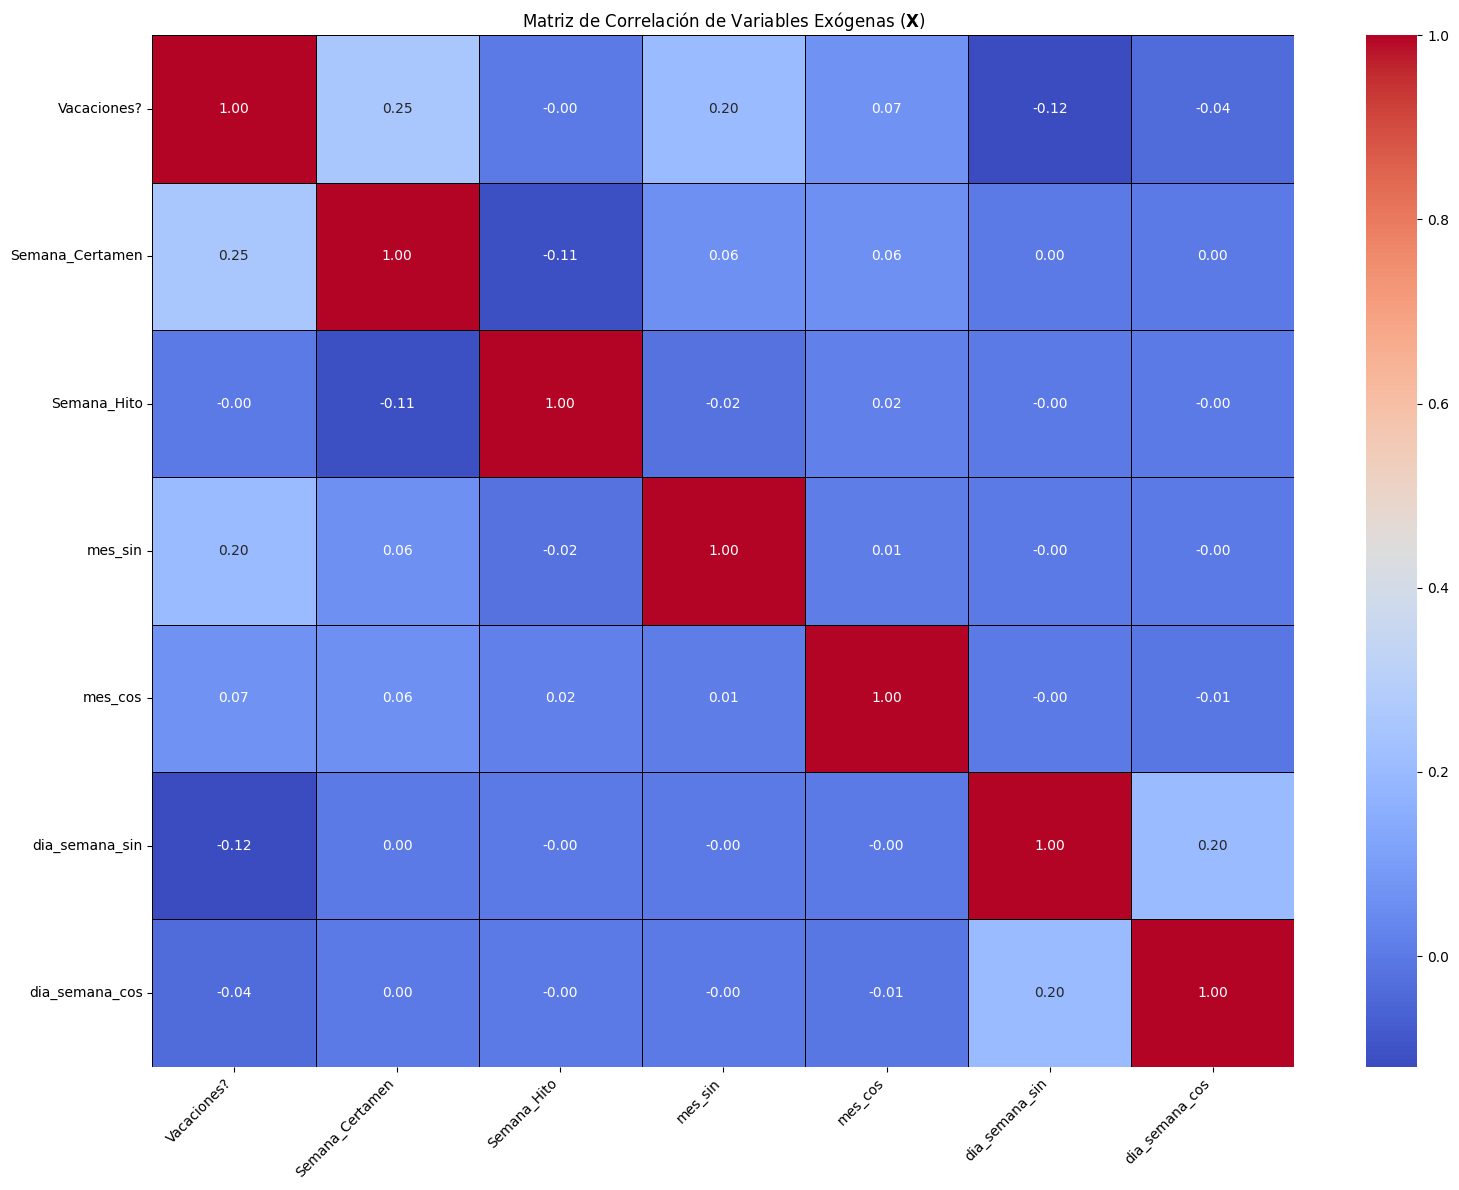

In [18]:
corr_matrix = X_sarimax.corr().round(2)
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=.5, linecolor='black')
plt.title('Matriz de Correlación de Variables Exógenas ($\mathbf{X}$)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

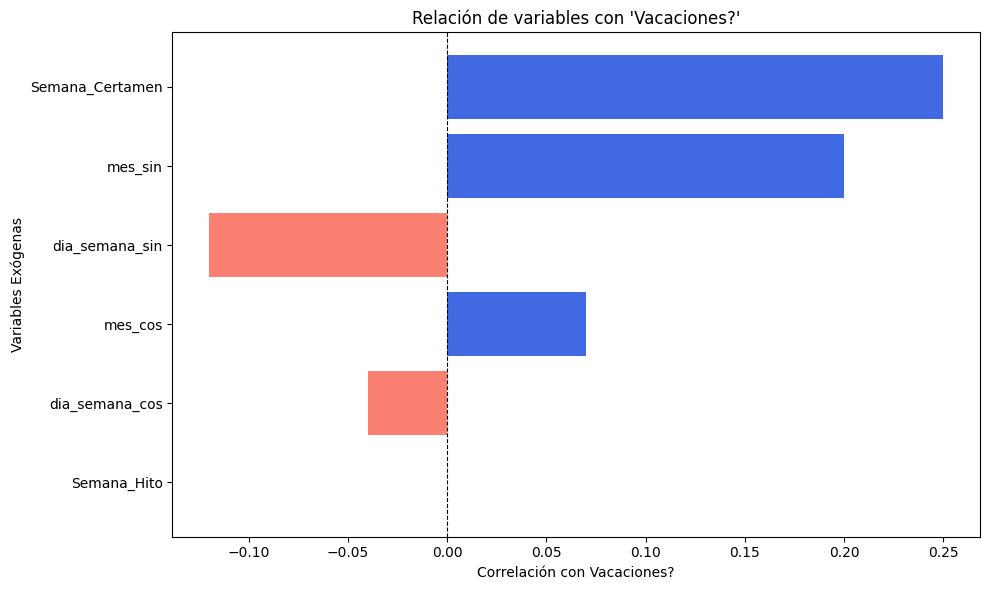

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Elige contra qué variable comparar 
variable_objetivo = corr_matrix.columns[0] 

# Extraemos las correlaciones de esa variable con el resto
importances = corr_matrix[variable_objetivo].drop(variable_objetivo) 

# Preparamos el DataFrame para el gráfico
features = importances.index
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})

# Ordenamos por valor absoluto para ver las más fuertes arriba
importance_df["Abs_Importance"] = importance_df["Importance"].abs()
importance_df = importance_df.sort_values(by="Abs_Importance", ascending=False).drop(columns=["Abs_Importance"])

# Graficamos
plt.figure(figsize=(10, 6))

# Usamos colores condicionales: Azul si es correlación positiva, Rojo si es negativa
colors = ['royalblue' if x > 0 else 'salmon' for x in importance_df["Importance"]]

plt.barh(importance_df["Feature"], importance_df["Importance"], color=colors)
plt.xlabel(f"Correlación con {variable_objetivo}")
plt.ylabel("Variables Exógenas")
plt.title(f"Relación de variables con '{variable_objetivo}'")
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8) # Línea en el cero
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

PASO 2: Especificación del Modelo (Grid Search AIC)

In [28]:
print("\n PASO 2: ESPECIFICACIÓN DEL MODELO (GRID SEARCH) ")
# --- Definición del espacio de búsqueda (usando rangos pequeños para eficiencia) ---
p = d = q = range(0, 2)            
P = D = Q = range(0, 2)
s = 7                              # Período estacional: semanal

pdq = list(product(p, d, q))
seasonal_pdq = list(product(P, D, Q, [s]))

best_aic = np.inf
best_order = None
best_seasonal_order = None

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = sm.tsa.SARIMAX(
                y_train, exog=X_train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False 
            )
            results = model.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

print(f"Mejor AIC encontrado: {best_aic:.2f}")
print(f"Mejor Orden No Estacional (p, d, q): {best_order}")
print(f"Mejor Orden Estacional (P, D, Q, s): {best_seasonal_order}")


FINAL_ORDER = best_order if best_order else (0, 0, 1)
FINAL_SEASONAL_ORDER = best_seasonal_order if best_seasonal_order else (1, 1, 1, 7)


 PASO 2: ESPECIFICACIÓN DEL MODELO (GRID SEARCH) 
Mejor AIC encontrado: 5009.83
Mejor Orden No Estacional (p, d, q): (1, 0, 1)
Mejor Orden Estacional (P, D, Q, s): (0, 1, 1, 7)


PASO 3: Estimación de Parámetros (Entrenamiento Final) 

In [29]:
print("\nPASO 3: ESTIMACIÓN DE PARÁMETROS (ENTRENAMIENTO FINAL)")

final_sarimax = sm.tsa.SARIMAX(
    y_train, exog=X_train, order=FINAL_ORDER, seasonal_order=FINAL_SEASONAL_ORDER,
    enforce_stationarity=False, enforce_invertibility=False
)
final_results = final_sarimax.fit(disp=False)
print(final_results.summary().tables[1])


PASO 3: ESTIMACIÓN DE PARÁMETROS (ENTRENAMIENTO FINAL)
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Vacaciones?     -1689.1547    113.530    -14.878      0.000   -1911.670   -1466.640
Semana_Certamen  -183.0989    324.629     -0.564      0.573    -819.361     453.163
Semana_Hito       -86.2834    144.704     -0.596      0.551    -369.898     197.331
mes_sin           370.0828    347.112      1.066      0.286    -310.244    1050.410
mes_cos            32.2188    379.476      0.085      0.932    -711.540     775.978
dia_semana_sin    611.6213     54.078     11.310      0.000     505.630     717.613
dia_semana_cos    145.6458     58.290      2.499      0.012      31.400     259.891
ar.L1               0.9658      0.022     43.646      0.000       0.922       1.009
ma.L1              -0.7023      0.053    -13.338      0.000      -0.805      -0.599
ma.S.L7            -

PASO 4: Diágnostico y Evaluación (Validación con y_test)


 PASO 4: DIAGNÓSTICO Y EVALUACIÓN 

 Diagnóstico Estadístico (Resumen del Modelo)
                                     SARIMAX Results                                     
Dep. Variable:                           Accesos   No. Observations:                  326
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -2493.914
Date:                           Wed, 03 Dec 2025   AIC                           5009.829
Time:                                   23:12:24   BIC                           5050.931
Sample:                                        0   HQIC                          5026.260
                                           - 326                                         
Covariance Type:                             opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Vacaciones?     -1689.1547   

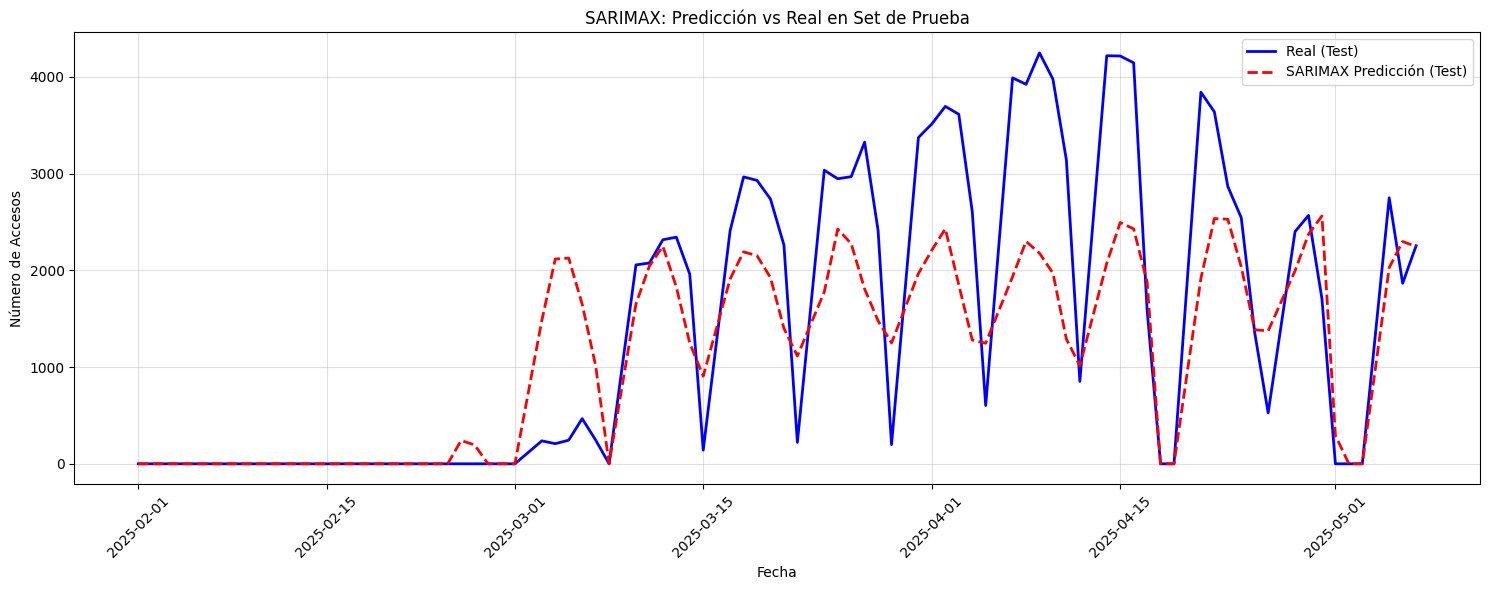

In [30]:
print("\n PASO 4: DIAGNÓSTICO Y EVALUACIÓN ")

# Diagnóstico estadístico (P-valores y Ljung-Box) 
print("\n Diagnóstico Estadístico (Resumen del Modelo)")
print(final_results.summary()) 

# Predicción en el set de prueba (Forecasting in-sample) 
forecast_steps = len(y_test)
prediction = final_results.get_forecast(steps=forecast_steps, exog=X_test) 
pred_mean = prediction.predicted_mean
pred_mean.index = y_test.index
pred_mean[pred_mean < 0] = 0

# Evaluación de Métricas 
rmse = np.sqrt(mean_squared_error(y_test.values, pred_mean.values))
mae = mean_absolute_error(y_test.values, pred_mean.values)
r2 = r2_score(y_test.values, pred_mean.values)

print("\n Métricas de Evaluación en Set de Prueba")
print(f"RMSE (Error Típico): {rmse:.2f}")
print(f"MAE (Error Absoluto): {mae:.2f}")
print(f"R² (Varianza Explicada): {r2:.4f}")

# Visualización de la Evaluación 
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Real (Test)', color='blue', linewidth=2)
plt.plot(y_test.index, pred_mean, label='SARIMAX Predicción (Test)', color='red', linestyle='--', linewidth=2)
plt.title('SARIMAX: Predicción vs Real en Set de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

PASO 5: Predicción (Forecasting a futuro).
Se utiliza el método Walk-Forward para predecir 7 días.


 PASO 5: PREDICCIÓN (WALK-FORWARD) CORREGIDO

--- Pronóstico a 7 días ---
             Prediccion
2025-05-08         468
2025-05-09           0
2025-05-10           0
2025-05-12         394
2025-05-13         817
2025-05-14         812
2025-05-15         382


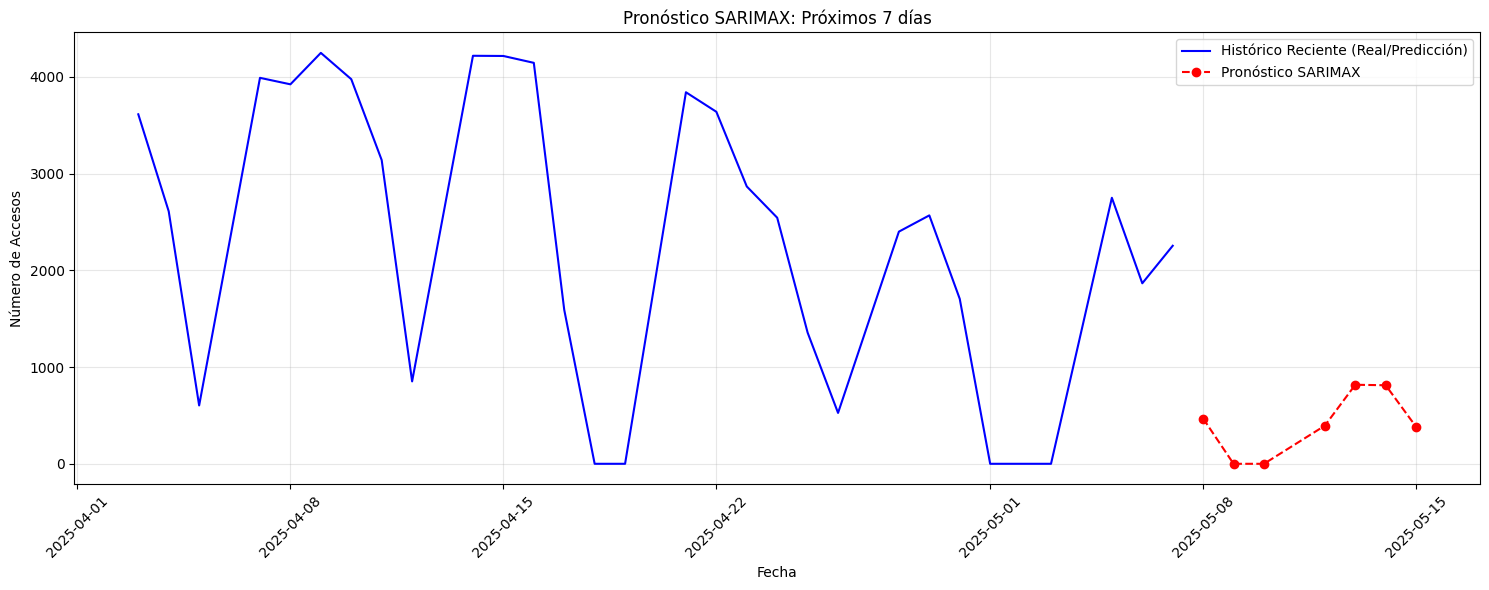

In [31]:
print("\n PASO 5: PREDICCIÓN (WALK-FORWARD) CORREGIDO")

DAYS_TO_PREDICT = 7
last_date = daily_counts_full['Fecha'].max()
future_dates_full = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=DAYS_TO_PREDICT * 2, freq='D')
future_dates = future_dates_full[future_dates_full.dayofweek != 6][:DAYS_TO_PREDICT]

current_data = daily_counts_full.copy().set_index('Fecha')
future_predictions = []

# Bucle para predicción recursiva (Walk-Forward)
for date in future_dates:
    # 1. CALCULAR LAS 7 FEATURES A PRIORI PARA EL DÍA FUTURO
    mes, weekday = date.month, date.weekday()
    mes_sin = np.sin(2 * np.pi * mes / 12)
    mes_cos = np.cos(2 * np.pi * mes / 12)
    dia_sin = np.sin(2 * np.pi * weekday / 7)
    dia_cos = np.cos(2 * np.pi * weekday / 7)
    
    # Valores de las features binarias para el futuro
    es_vacaciones = 0 # Asume 0 si no tienes un calendario futuro
    semana_semestre_val = date.isocalendar().week % 25
    es_semana_certamen = 1 if semana_semestre_val in [6, 7] else 0
    es_semana_hito = 1 if semana_semestre_val in [1, 15, 20] else 0

    # Crear DataFrame Exógeno con las 7 variables (COINCIDE con el entrenamiento)
    exog_future = pd.DataFrame({
        'Vacaciones?': [es_vacaciones], 
        'Semana_Certamen': [es_semana_certamen], 
        'Semana_Hito': [es_semana_hito],
        'mes_sin': [mes_sin], 'mes_cos': [mes_cos], 
        'dia_semana_sin': [dia_sin], 'dia_semana_cos': [dia_cos]
    }, index=[date])

    # 2. Predecir 1 paso
    forecast = final_results.get_forecast(steps=1, exog=exog_future)
    pred_value = np.maximum(forecast.predicted_mean.iloc[0], 0)
    
    # 3. Actualizar el historial (se requiere para futuros cálculos SARIMA internos)
    future_predictions.append(pred_value)
    current_data.loc[date, 'Accesos'] = pred_value

# Resultado Final
df_forecast = pd.DataFrame({'Prediccion': np.round(future_predictions).astype(int)}, index=future_dates)
print("\n--- Pronóstico a 7 días ---\n", df_forecast)

# Visualización del Pronóstico
plt.figure(figsize=(15, 6))
hist_slice = current_data['Accesos'].iloc[-DAYS_TO_PREDICT-30:-DAYS_TO_PREDICT] 
plt.plot(hist_slice.index, hist_slice.values, label='Histórico Reciente (Real/Predicción)', color='blue')
plt.plot(df_forecast.index, df_forecast['Prediccion'], label='Pronóstico SARIMAX', linestyle='--', marker='o', color='red')
plt.title(f'Pronóstico SARIMAX: Próximos {DAYS_TO_PREDICT} días')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()